# Synthetic Seismograms: Aki & Richards Double-Couple Source

This notebook demonstrates how to compute synthetic seismograms for a point double-couple source in a homogeneous whole space, following Aki & Richards' formulations. You can specify the moment rate function, source mechanism, and source/receiver positions.

In [14]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt

# Time/Frequency

In [16]:
# 5. Time axis
nt = 2000
dt = 0.005
t = np.arange(nt) * dt

In [ ]:
# Source moment rate and Green's function definitions

def moment_rate(t, t0=1.0, sigma=0.1):
    """Gaussian moment rate function"""
    return np.exp(-0.5*((t-t0)/sigma)**2) / (sigma * np.sqrt(2*np.pi))

def brune_moment_rate(t, t0=1.0, tau=0.1):
    """Causal Brune-like source time function (moment rate)"""
    s = (t - t0) / tau
    stf = np.zeros_like(t)
    mask = s >= 0
    stf[mask] = s[mask] * np.exp(-s[mask]) / tau
    return stf


def greens_function_full(r, t, alpha, beta, rho):
    """
    Full Green's function (radial, time domain) for a point force in a whole space.
    Includes near, intermediate, and far-field terms.
    """
    # Parameters for delta approximation
    eps = t[1] - t[0]
    def delta_func(tau):
        return np.exp(-0.5 * (tau/eps)**2) / (eps * np.sqrt(2*np.pi))
    def delta_integral(tau):
        return 0.5 * (1 + np.erf(tau / (eps * np.sqrt(2))))
    # calculate the integral of a function between t_a and t_b
    
    def delta_prime(tau):
        return -tau / (eps**2) * delta_func(tau)
    def delta_double_integral(tau):
        return tau * delta_integral(tau) + eps**2 * delta_func(tau)
    
    G = np.zeros_like(t)
    # Far-field (1/r)
    G += (1/(4*np.pi*rho*alpha**3*r)) * delta_func(t - r/alpha)
    G -= (1/(4*np.pi*rho*beta**3*r)) * delta_func(t - r/beta)
    # Intermediate-field (1/r^2)
    G += (1/(4*np.pi*rho*alpha**2*r)) * delta_integral(t - r/alpha)
    G -= (1/(4*np.pi*rho*beta**2*r)) * delta_integral(t - r/beta)
    # G += (1/(4*np.pi*rho*r**2)) * (1/beta - 1/alpha) * delta_prime(t - r/alpha)
    # Near-field (1/r^3)
    G += (1/(4*np.pi*rho*r**3)) * (delta_func(t) - delta_func(t - r/alpha))
    return G

def zne_to_lqt_matrix(theta, phi):
    """Create rotation matrix from ZNE to LQT coordinates."""
    R = np.zeros((3,3))
    R[0,0] = np.sin(theta) * np.cos(phi)  # L
    R[0,1] = np.sin(theta) * np.sin(phi)
    R[0,2] = np.cos(theta)
    R[1,0] = np.cos(theta) * np.cos(phi)  # Q
    R[1,1] = np.cos(theta) * np.sin(phi)
    R[1,2] = -np.sin(theta)
    R[2,0] = -np.sin(phi)               # T
    R[2,1] = np.cos(phi)
    R[2,2] = 0
    return R

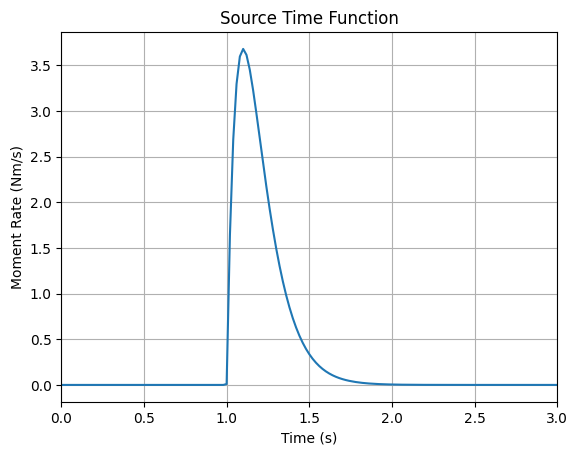

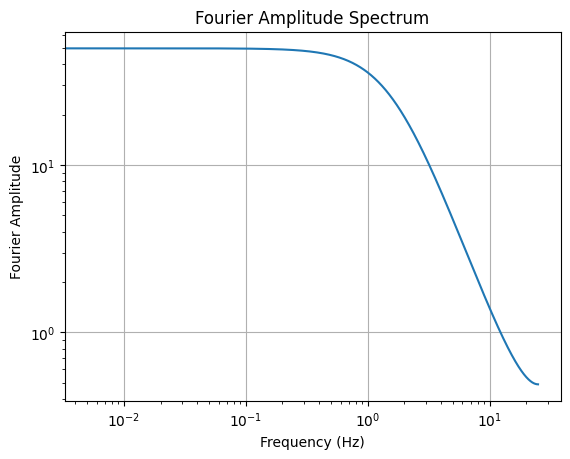

In [4]:
# plot the source time function and its Fourier amplitude spectrum
# 3. Plot moment rate function


# 2. Double-couple moment tensor (strike-slip example)
M0 = 1e15  # seismic moment (Nm)
M = np.array([[0, 1, 0],
              [1, 0, 0],
              [0, 0, 0]]) * M0


t = np.linspace(0, 200, 10000)
mt = brune_moment_rate(t)
plt.plot(t, mt)
plt.xlabel('Time (s)')
plt.ylabel('Moment Rate (Nm/s)')
plt.title('Source Time Function')
plt.grid()
plt.xlim(0, 3)
plt.show()

freq = np.fft.rfftfreq(len(t), d=(t[1]-t[0]))
mt_f = np.fft.rfft(mt)
plt.loglog(freq, np.abs(mt_f))
plt.xlabel('Frequency (Hz)')    
plt.ylabel('Fourier Amplitude')
plt.title('Fourier Amplitude Spectrum')
plt.grid()

# Medium Properties

In [5]:
# 4. Medium properties
rho = 3000  # density (kg/m^3)
vp = 6000   # P-wave speed (m/s)
vs = 3464   # S-wave speed (m/s)


# Source & Receive Location(s)

Text(0.5, 1.0, 'Source and Receiver Geometry')

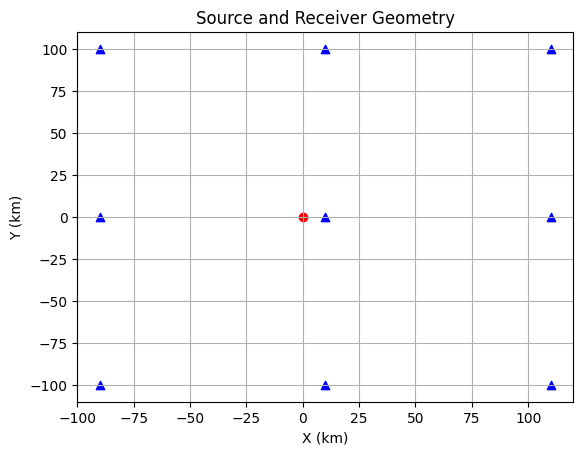

In [6]:
# 3. Source and receiver positions in ZNE coordinates
H = 10e3  # source depth in meters
source = np.array([-H, 0, 0])  # at origin and depth H
# array of receiver locations at the surface in a small grid 10 km away from the epicenter
N_rec = 9 # for a 3x3 grid
Xmean, Ymean = 10e3, 0  # center of the receiver grid
Xmax = 100e3  # extent of the receiver grid
x_rec = np.linspace(-Xmax, Xmax, int(np.sqrt(N_rec))) + Xmean
y_rec = np.linspace(-Xmax, Xmax, int(np.sqrt(N_rec))) + Ymean
X_rec, Y_rec = np.meshgrid(x_rec, y_rec)
Z_rec = np.zeros_like(X_rec)  # surface receivers
receivers = np.vstack([ Z_rec.ravel(), X_rec.ravel(), Y_rec.ravel()]).T

# 7. Calculate take-off angles (for this geometry, theta=0, phi=0)
r_vec = receivers - source
# create the r, theta, phi arrays
r = np.linalg.norm(r_vec, axis=1)
theta = np.arccos(r_vec[:,0] / r)  # polar angle from vertical
phi = np.arctan2(r_vec[:,2], r_vec[:,1])

# plot the receivers
plt.figure()
plt.scatter(receivers[:,1]/1000, receivers[:,2]/1000, marker='^', c='blue', label='Receivers')
plt.scatter(source[1]/1000, source[2]/1000, c='red', label='Source')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.grid()
plt.title('Source and Receiver Geometry')


# Define the Green's function

In [7]:

# 6. Compute Green's function for whole space (far-field, Aki & Richards eq. 4.88)
def greens_function(r, theta, phi, t, c):
    # r: source-receiver distance
    # theta, phi: take-off angles (radians)
    # t: time array
    # c: wave speed
    G = np.zeros_like(t)
    travel_time = r / c
    print(travel_time)
    idx = np.argmin(np.abs(t - travel_time))
    G[idx] = 1.0 / (4 * np.pi * rho * c**3 * r)

    return G

22.484562605386735


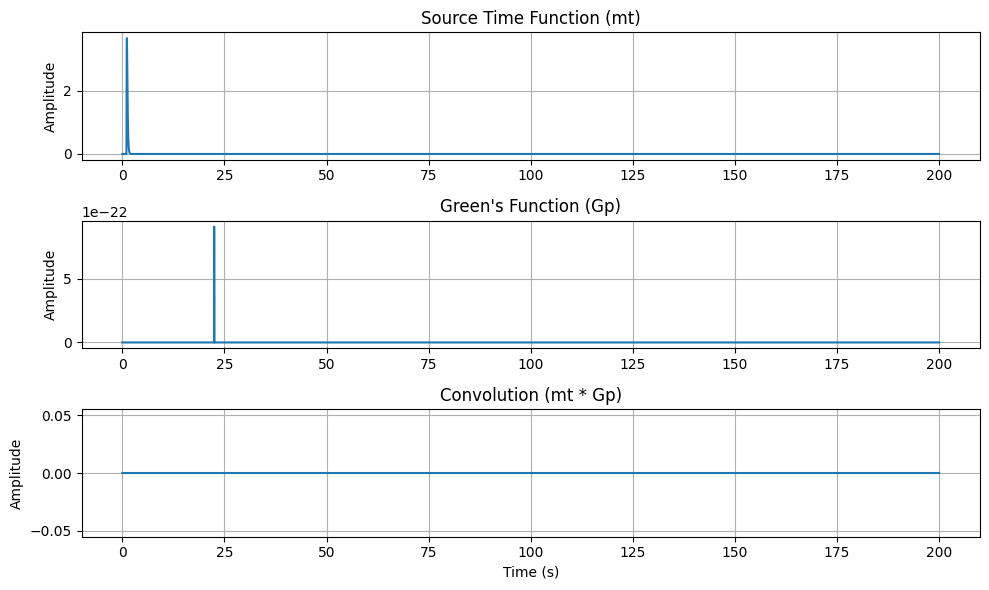

Max of mt: 3.679e+00, Max of Gp: 9.103e-22, Max of convolution: 0.000e+00
Travel time (r/vp): 22.48 s, t range: 0.00 to 200.00 s


In [8]:
# Debug: Check Green's function and source time function overlap
# For a given receiver, plot mt, Gp, and their convolution
irec = 0  # index of receiver to check
Gp = greens_function(r[irec], theta[irec], phi[irec], t, vp)
mt = brune_moment_rate(t)
conv = np.convolve(mt, Gp, mode='same')

plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(t, mt)
plt.title('Source Time Function (mt)')
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(3,1,2)
plt.plot(t, Gp)
plt.title("Green's Function (Gp)")
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(3,1,3)
plt.plot(t, conv)
plt.title('Convolution (mt * Gp)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
plt.show()

print(f'Max of mt: {np.max(mt):.3e}, Max of Gp: {np.max(Gp):.3e}, Max of convolution: {np.max(conv):.3e}')
print(f'Travel time (r/vp): {r[irec]/vp:.2f} s, t range: {t[0]:.2f} to {t[-1]:.2f} s')

# Generate synthetic seismograms

In [9]:
r/1000

array([134.90737563, 100.99504938, 148.99664426,  90.55385138,
        14.14213562, 110.45361017, 134.90737563, 100.99504938,
       148.99664426])

In [10]:
r/vp

array([22.48456261, 16.83250823, 24.83277404, 15.09230856,  2.3570226 ,
       18.40893503, 22.48456261, 16.83250823, 24.83277404])

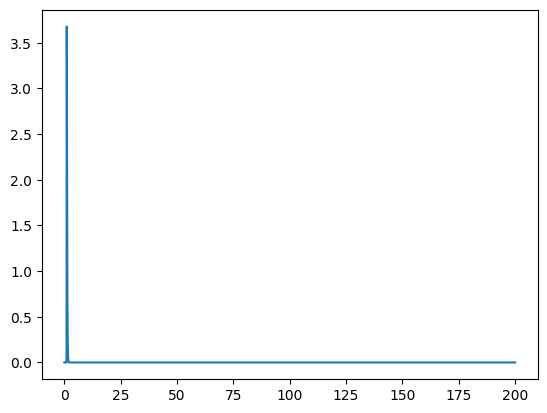

In [11]:
plt.plot(t,mt)

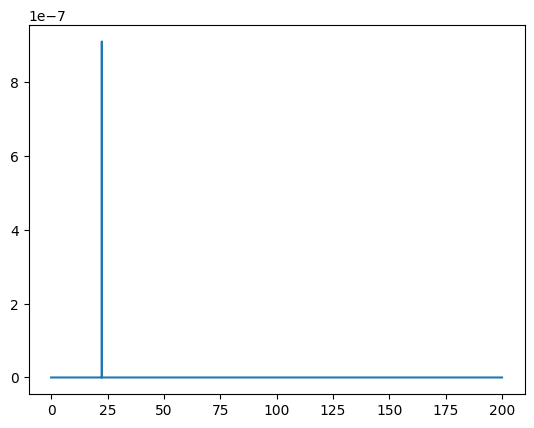

In [12]:
plt.plot(t,Gp*M0)

In [13]:

for i in range(N_rec):
    Gp = greens_function(r[i], theta[i], phi[i], t, vp)
    mt = brune_moment_rate(t)
    Up[i, :] = np.convolve(mt, Gp,mode='same')
    print(np.max(Up[i,:]))

22.484562605386735


NameError: name 'Up' is not defined

22.484562605386735
16.832508230603462
24.8327740429189
15.09230856356236
2.3570226039551585
18.408935028645434
22.484562605386735
16.832508230603462
24.8327740429189
38.94554723796779
29.15561471813533
43.01288806510202
26.14141206159762
4.082602662739881
31.886146123519808
38.94554723796779
29.15561471813533
43.01288806510202


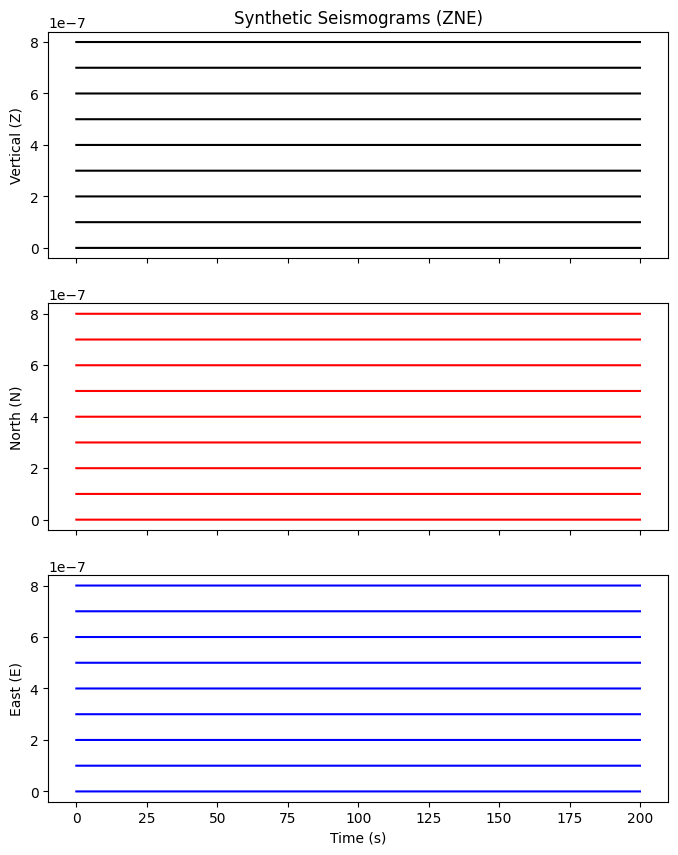

In [ ]:

# 8. Generate seismogram (vertical component, P-wave only for simplicity)
# P waves
tmax = 200
dt = 0.02
t = np.arange(0, tmax, dt)
Up = np.zeros((N_rec, len(t)))
for i in range(N_rec):
    Gp = greens_function(r[i], theta[i], phi[i], t, vp)
    mt = brune_moment_rate(t)
    Up[i, :] = np.convolve(mt, Gp)
# S waves
Us = np.zeros((N_rec, len(t)))
for i in range(N_rec):
    Gs = greens_function(r[i], theta[i], phi[i], t, vs)
    mt = brune_moment_rate(t)
    Us[i, :] = np.convolve(mt, Gs, mode='same')

# Combine P and S for LQT components (approximate)
U_lqt = np.zeros((N_rec, 3, len(t)))
U_lqt[:, 0, :] = Up  # L component (P-wave)
U_lqt[:, 1, :] = Us  # Q component (S-wave)
U_lqt[:, 2, :] = Us  # T component 



# for each receiver, compute the rotation matrix and rotate the seismograms
U_zne = np.zeros((N_rec, 3, len(t)))
for i in range(N_rec):
    R = zne_to_lqt_matrix(theta[i], phi[i])
    # rotate with the transpose (LQT to ZNE)
    U_zne[i, :, :] = R.T @ np.squeeze(U_lqt[i, :, :])

# plot the seismograms sorted by distance, 3 component, 3 subplots
fig, ax = plt.subplots(3,1, figsize=(8,10), sharex=True)

for i in range(N_rec):
    ax[0].plot(t, U_zne[i,0,:]*1E14 + i * 1e-7, 'k')  # Z
    ax[1].plot(t, U_zne[i,1,:]*1E14 + i * 1e-7, 'r')  # N
    ax[2].plot(t, U_zne[i,2,:]*1E14 + i * 1e-7, 'b')  # E
ax[0].set_ylabel('Vertical (Z)')
ax[1].set_ylabel('North (N)')
ax[2].set_ylabel('East (E)')
ax[2].set_xlabel('Time (s)')
ax[0].set_title('Synthetic Seismograms (ZNE)')
plt.show()

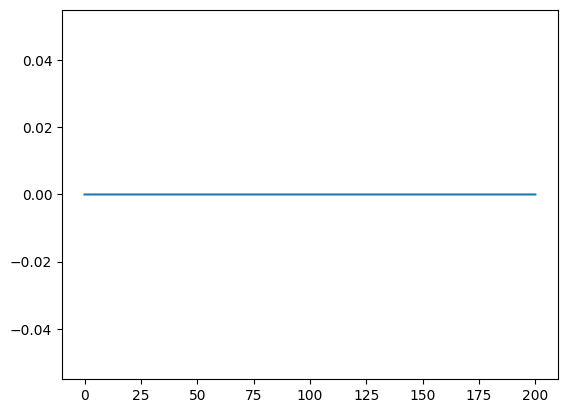

In [ ]:
plt.plot(t, U_zne[5,0,:])

In [ ]:
# Set all main parameters in one place
# --- Model parameters ---
nt = 2000           # number of time samples
nfft = 10000        # for plotting

dt = 0.005          # time step (s)
t = np.arange(nt) * dt

# Medium properties
rho = 3000          # density (kg/m^3)
vp = 6000           # P-wave speed (m/s)
vs = 3464           # S-wave speed (m/s)

# Source and receiver geometry
H = 10e3            # source depth in meters
source = np.array([-H, 0, 0])  # at origin and depth H
N_rec = 9           # for a 3x3 grid
Xmean, Ymean = 10e3, 0  # center of the receiver grid
Xmax = 100e3        # extent of the receiver grid
x_rec = np.linspace(-Xmax, Xmax, int(np.sqrt(N_rec))) + Xmean
y_rec = np.linspace(-Xmax, Xmax, int(np.sqrt(N_rec))) + Ymean
X_rec, Y_rec = np.meshgrid(x_rec, y_rec)
Z_rec = np.zeros_like(X_rec)  # surface receivers
receivers = np.vstack([ Z_rec.ravel(), X_rec.ravel(), Y_rec.ravel()]).T

# Calculate take-off angles
r_vec = receivers - source
r = np.linalg.norm(r_vec, axis=1)
theta = np.arccos(r_vec[:,0] / r)  # polar angle from vertical
phi = np.arctan2(r_vec[:,2], r_vec[:,1])